In [117]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from pystoi import stoi # entre 0 et 1. Plus c'est proche de 1, mieux c'est
import scipy
import torchmetrics
from torch.utils.data import DataLoader
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
import torch
import torch.nn as nn
import torch.nn.functional as F
import IPython.display as ipd
from scipy.signal import stft, istft

import tqdm
import pandas as pd

In [118]:
SAMPLERATE = 8000

Localisation des fichiers : 

In [119]:

test_files_noise = os.listdir('./data/Audio/denoising/test/test/')
train_files_noise = os.listdir('./data/Audio/denoising/train/train/')
test_files_clean = os.listdir('./data/Audio/voice_origin/test/test/')
train_files_clean = os.listdir('./data/Audio/voice_origin/train/train/')

Visualisation de quelques signaux

In [120]:
index=9
file_clean='./data/Audio/voice_origin/train/train/' + train_files_clean[index]
file_noise='./data/Audio/denoising/train/train/' + train_files_noise[index]
samplerate_clean, data_clean = wavfile.read(file_clean) # sample rate is the sample freqnency of the audio
samplerate_noise, data_noise = wavfile.read(file_noise)


attention, on travaille avec les short term fourier transform, pas les spectrogrammes

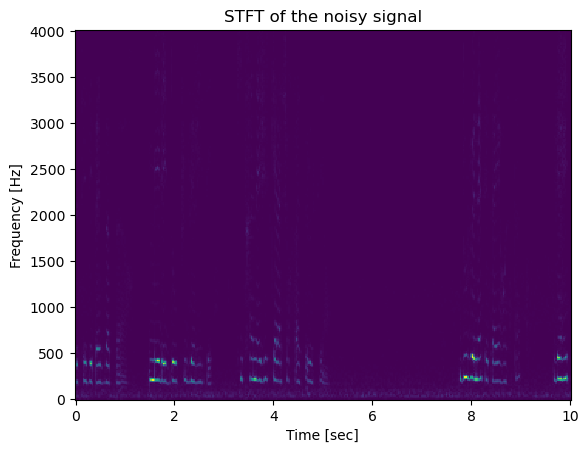

In [121]:
f, t, Zxx=stft(data_noise, fs=samplerate_noise, nperseg=500) # short time fourier transform
plt.pcolormesh(t, f, (np.abs(Zxx)), vmin=0, vmax=0.1)
# plt.plot()
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')
plt.title('STFT of the noisy signal')
plt.show()

In [122]:
ipd.Audio(data_noise, rate=samplerate_noise)

In [123]:
t, reconstruction = istft(Zxx, fs=samplerate_noise) # on inverse pour retrouver le signal
ipd.Audio(reconstruction, rate=samplerate_noise)

In [124]:
ipd.Audio(data_clean, rate=samplerate_clean)

Bon bah on voit bien que reconstruction et data_noise sont les mêmes 

On commence par transformer les données en stft et les stocker dans data. 
On stocke le stft normalisé (toutes les valeurs sont entre 0 et 1). 
Ca va peut-être poser problème, à voir si on peut travailler avec les stft normaux ou les log stft

In [129]:
convert_files = True 
# set to True to convert the files to spectrogrammes
if convert_files: 
    np.random.seed(0)
    for i in tqdm.tqdm(range(len(test_files_noise))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        pd.DataFrame(data=Zxx/np.max(Zxx)).to_csv('./data/spectrogrammes/test/noisy/' + file + '.csv')

    for i in tqdm.tqdm(range(len(test_files_clean))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/voice_origin/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        pd.DataFrame(data=Zxx/np.max(Zxx)).to_csv('./data/spectrogrammes/test/origin/' + file + '.csv')
        
    for i in tqdm.tqdm(range(len(train_files_noise))):
        file = train_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/train/train/' + file)
        samplerate_clean, data_clean=wavfile.read('./data/Audio/voice_origin/train/train/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        frequencies_clean, times_clean, Zxx_clean = stft(data_clean, fs=samplerate_clean, nperseg=500)
        if np.random.random() > 0.8 :
            pd.DataFrame(data=Zxx/np.max(Zxx)).to_csv('./data/spectrogrammes/validation/noisy/' + file + '.csv')
            pd.DataFrame(data=Zxx_clean/np.max(Zxx_clean)).to_csv('./data/spectrogrammes/validation/origin/' + file + '.csv')
        else : 
            pd.DataFrame(data=Zxx/np.max(Zxx)).to_csv('./data/spectrogrammes/train/noisy/' + file + '.csv')
            pd.DataFrame(data=Zxx_clean/np.max(Zxx_clean)).to_csv('./data/spectrogrammes/train/origin/' + file + '.csv')


100%|██████████| 2118/2118 [25:21<00:00,  1.39it/s] 


Création de datasets d'entrainement, de validation et de test. 

In [136]:
file = train_files_noise[0]

In [154]:
samplerate, data = wavfile.read('./data/Audio/denoising/train/train/' + file)
#  zxx : 
frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
Zxx[0][0]

(0.00088552304+0j)

In [157]:
np.array(pd.read_csv('./data/spectrogrammes/train/noisy/' + file + '.csv').drop(columns='Unnamed: 0'))[0][0]

'(0.005683104507625103-0.002066834596917033j)'

In [130]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.X = os.listdir(path_to_data + 'noisy/')
        self.Y = os.listdir(path_to_data + 'origin/')

    def __len__(self):
        assert len(self.X) == len(self.Y)
        return len(self.X)

    def __getitem__(self, idx):
        noised = np.array([pd.read_csv(self.path_to_data + 'noisy/' + self.X[idx]).drop(columns='Unnamed: 0')])
        origin = np.array( [pd.read_csv(self.path_to_data + 'origin/' + self.Y[idx]).drop(columns='Unnamed: 0')])
        return torch.tensor(noised), torch.tensor(origin) # 1, 129, 357 chacuns 

Création de dataloaders

In [131]:
dataloader_test = DataLoader(Mydataset('./data/spectrogrammes/test/'), batch_size=10 , shuffle=True)
dataloader_train = DataLoader(Mydataset('./data/spectrogrammes/train/'), batch_size=10 , shuffle=True)
dataloader_validation = DataLoader(Mydataset('./data/spectrogrammes/validation/'), batch_size=10 , shuffle=True)

for batch in dataloader_test :
  print(batch[0].shape, batch[1].shape)
  break
print("il n'y a qu'un canal au début")

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

Dummy model as a baseline 

In [ ]:
class Dummy (nn.Module):
  def __init__(self): # simple modèle de convolution avec 2 couches
    super(Dummy, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(11, 11), stride=2, padding = 'valid') # stride = nombre de pixels que l'on saute
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(8, 8),stride=2)
    self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(8, 8),stride=2)
    self.deconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(11, 11), stride=2)
    

  def forward(self, x): # x = [10, 1, 129, 357] 
    print(x.shape)
    x = F.relu(self.conv1(x)) # [10, 16, 60, 174]
    print(x.shape)
    x = F.relu(self.conv2(x)) # [10, 32, 27, 84]
    print(x.shape)
    x = F.relu(self.deconv1(x)) #[10, 16, 60, 174]
    print(x.shape)
    x = F.relu(self.deconv2(x)) # [10, 1, 129, 357]
    print(x.shape)
    return x
# VERIFIER LES DIMENSIONS DEPUIS QUE LE RESEAU A CHANGE 


In [ ]:
# vérifier les dimensions à chaque étape
model = Dummy()
for batch in dataloader_test :
  print(batch[0].shape, batch[1].shape)
  print(model(batch[0]).shape)
  break

Entrainement du modèle : 

In [50]:
chemin_vers_sauvegarde_model ='./dummy_model.pth'

In [ ]:
# set train_dummy to True to train the model
train_dummy = True
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = Dummy()
n_epochs=200
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device)
loss_train=[]
loss_val=[]
if train_dummy:
    for epoch in (range(n_epochs)):
        if epoch%10==0:
            print(epoch)
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for batch_x,batch_y in dataloader_train:
            counttrain+=1
            batch_x.to(device)
            batch_y = batch_y.long()
            batch_y.to(device)
            optimizer.zero_grad()
            mask_predicted = model(batch_x.float())
            batch_y_predicted = batch_x * mask_predicted
            l = loss(batch_y_predicted, batch_y)
            l.backward()
            losstrain+=l
            optimizer.step()
        for batch_x,batch_y in dataloader_validation:
            countval+=1
            batch_x.to(device)
            batch_y.to(device)
            with torch.no_grad():
                batch_y_predicted = model(batch_x)
                l = loss(batch_y_predicted, batch_y.long())
                lossval+=l
        if epoch%10==0:
            print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
        loss_train.append(losstrain/counttrain)
        loss_val.append(lossval/countval)
        
    torch.save(model, chemin_vers_sauvegarde_model)


    # saving the losses in txt files : 
    loss_list_val=[loss_val[i].detach().numpy() for i in range(len(loss_val))]
    loss_list_train=[loss_train[i].detach().numpy() for i in range(len(loss_train))]

    with open('./loss_val_dummy.txt', 'w') as f : 
        for elt in loss_list_val : 
            f.write(str(elt) + '\n')

    with open('./loss_train_dummy.txt', 'w') as f : 
        for elt in loss_list_train : 
            f.write(str(elt) + '\n')

AttributeError: module 'torch.nn' has no attribute 'L2Loss'

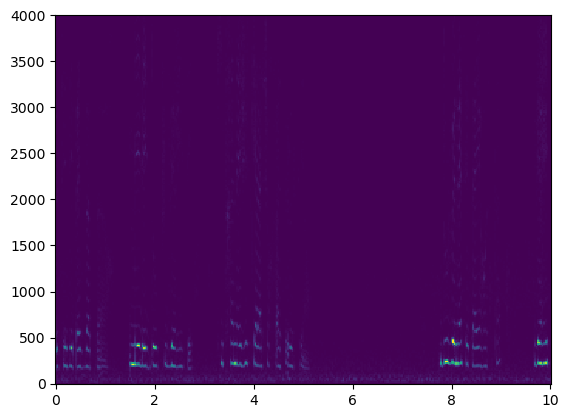

(80000,)


In [ ]:
f, t, Zxx=stft(data_noise, fs=samplerate_noise, nperseg=500)
plt.pcolormesh(t, f, (np.abs(Zxx)), vmin=0, vmax=0.1)
# plt.plot()
plt.show()
ipd.Audio(data_noise, rate=samplerate_noise)
t, x = istft(Zxx, fs=samplerate_noise)
print(x.shape)

In [95]:
ipd.Audio(data_noise,  rate=samplerate_noise)

In [93]:
ipd.Audio(x, rate=samplerate_noise)

## Evaluation des modèles 

In [61]:
# transform a spectrogram to an audio file 
def spectrogram_to_audio(spectrogram):
    return np.array([np.fft.irfft(spectrogram[i]) for i in range(spectrogram.shape[0])])
spectrogram_to_audio(Sxx).shape

(129, 712)

In [ ]:
def denoise(model, file_name, my_set='test'): 
    samplerate, data = wavfile.read('data/Audio/'+my_set+'/'+file_name)
    frequencies, times, Sxx = scipy.signal.spectrogram(data, fs=samplerate)
    assert Sxx.shape == (129, 357)
    Sxx = torch.tensor(np.array([Sxx/np.max(Sxx)]))
    denoised = model(Sxx.float())
    denoised = denoised.detach().numpy()

In [ ]:
stoi(data_clean, data_clean, SAMPLERATE, extended=False)

0.9999999999999999